# Imports and code to run on TPU

In [ ]:
#BEFORE EXECUTING PLEASE SWITCH RUNTIME TO TPU AND UPLOAD THE 4 FILES FOR THE DATASETS IN
#APPROPRIATELY NAMED FOLDERS (AS DONE IN THE BASELINE CODE)
#Making necessary imports and installing lightgbm


!pip install lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import optimizers, losses, activations, models, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, Bidirectional, LSTM, GRU, SimpleRNN, Activation, BatchNormalization, LayerNormalization, GaussianDropout, SpatialDropout1D, AveragePooling1D, Flatten
from sklearn.metrics import f1_score, accuracy_score
import os
import lightgbm as lgb

from keras.metrics import AUC
from sklearn.metrics import confusion_matrix
from keras.models import load_model



In [ ]:
#TPU setup to accelerate computations

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.40.16.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.40.16.42:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Data loading : MITBIH and PTBDB

In [ ]:
#Importing MITBIH dataset

df_train = pd.read_csv("../input/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("../input/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [ ]:
#Importing PTBDB dataset

df_1 = pd.read_csv("../input/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("../input/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train_ptbdb, df_test_ptbdb = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])


Y_ptbdb = np.array(df_train_ptbdb[187].values).astype(np.int8)
X_ptbdb = np.array(df_train_ptbdb[list(range(187))].values)[..., np.newaxis]

Y_test_ptbdb = np.array(df_test_ptbdb[187].values).astype(np.int8)
X_test_ptbdb = np.array(df_test_ptbdb[list(range(187))].values)[..., np.newaxis]

## Data distribution and imbalance

Text(0, 0.5, 'Proportion in test set')

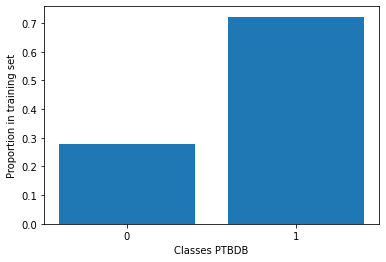

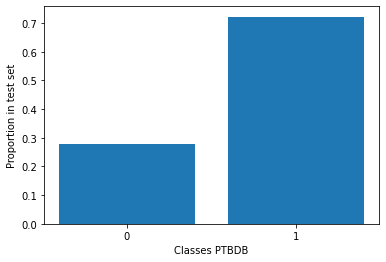

In [ ]:
class_names = [str(i) for i in range(2)]
labels, counts = np.unique(Y_ptbdb, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(labels)
ax.set_xlabel('Classes PTBDB')
ax.bar(labels, counts/Y_ptbdb.shape[0], align='center')
ax.set_ylabel("Proportion in training set")

labels, counts = np.unique(Y_test_ptbdb, return_counts=True)
fig, ax = plt.subplots()
ax.set_xticks(labels)
ax.set_xlabel('Classes PTBDB')
ax.bar(labels, counts/Y_test_ptbdb.shape[0], align='center')
ax.set_ylabel("Proportion in test set")

Text(0, 0.5, 'Proportion in test set')

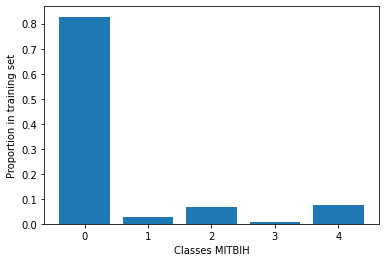

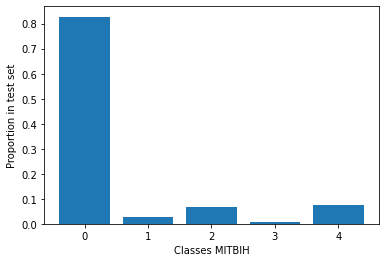

In [ ]:
class_names = [str(i) for i in range(5)]
labels, counts = np.unique(Y, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(labels)
ax.set_xlabel('Classes MITBIH')
ax.bar(labels, counts/Y.shape[0], align='center')
ax.set_ylabel("Proportion in training set")

labels, counts = np.unique(Y_test, return_counts=True)
fig, ax = plt.subplots()
ax.set_xticks(labels)
ax.set_xlabel('Classes MITBIH')
ax.bar(labels, counts/Y_test.shape[0], align='center')
ax.set_ylabel("Proportion in test set")

## ECG Graphs

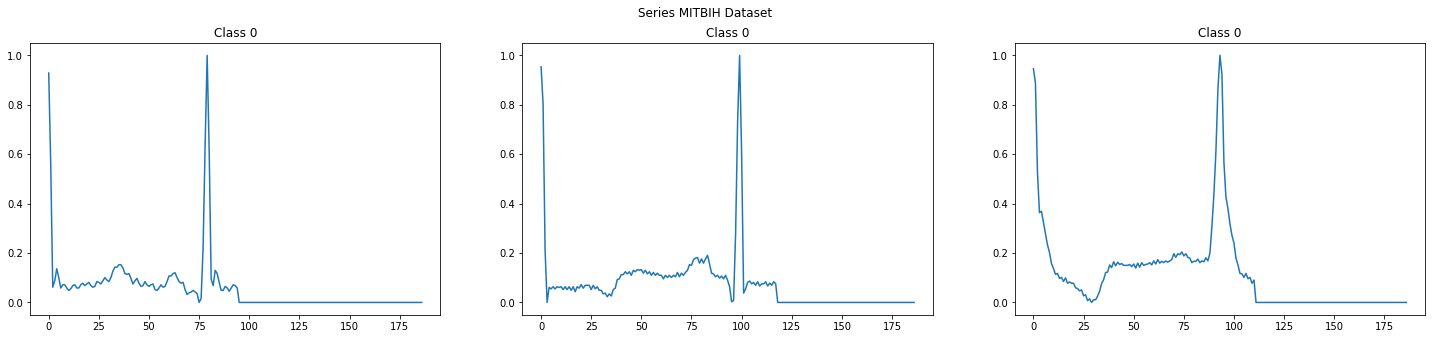

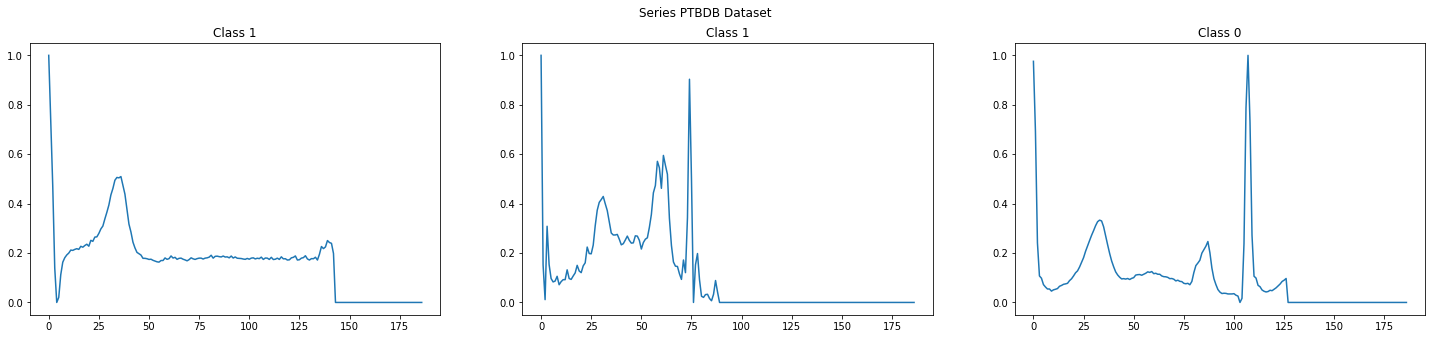

In [ ]:
plt.figure(figsize=(25,5))
plt.suptitle("Series MITBIH Dataset")
for j in range(3):
  plt.subplot(1,3,j+1)
  plt.plot(X[j])
  plt.title("Class " + str(Y[j])) 


plt.figure(figsize=(25,5))
plt.suptitle("Series PTBDB Dataset")
for j in range(3):
  plt.subplot(1,3,j+1)
  plt.plot(X_ptbdb[j])
  plt.title("Class " + str(Y_ptbdb[j])) 

## Define ROC and PR

In [ ]:
# define metrics
AUCROC = AUC(curve='ROC')
AUCPR = AUC(curve='PR')

# Task 1 : Vanilla CNNs and RNNs

## Vanilla CNN

### PTBDB

In [ ]:
# Vanilla CNN ptbdb

def get_model1():
    nclass = 1
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=[AUCROC,AUCPR,'acc'])
    model.summary()
    return model

def get_model11():
    nclass = 1
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=[AUCROC,AUCPR,'acc'])
    model.summary()
    return model

def get_model17():
    nclass = 1
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.tanh, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.tanh, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.tanh, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.tanh, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.tanh, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.tanh, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.tanh, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.tanh, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=[AUCROC,AUCPR,'acc'])
    model.summary()
    return model


In [ ]:
fitCNN = True #in all the code put True if you want to fit the model from 0 or False if you want to load the pre-trained h5 files

if fitCNN:
    #model 1
    model1 = get_model1()
    file_path = "model1_cnn_ptbdb.h5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]  # early

    history1 = model1.fit(X_ptbdb, Y_ptbdb, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
    model1.load_weights(file_path)

    pred_test = model1.predict(X_test_ptbdb)
    pred_test = (pred_test>0.5).astype(np.int8)

    f1 = f1_score(Y_test_ptbdb, pred_test)

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test_ptbdb, pred_test)

    print("Test accuracy score : %s "% acc)

    # Test f1 score : 0.9930935937127887 
    # Test accuracy score : 0.9900377877018207
    # AUCROC: 0.9993
    # AUCPR:  0.999


    #model 11
    model11 = get_model11()
    file_path = "model11_cnn_ptbdb.h5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]  # early

    history11 = model11.fit(X_ptbdb, Y_ptbdb, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
    model11.load_weights(file_path)

    pred_test11_ptbdb = model11.predict(X_test_ptbdb)
    pred_test11_ptbdb = (pred_test11_ptbdb>0.5).astype(np.int8)

    f1 = f1_score(Y_test_ptbdb, pred_test11_ptbdb)

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test_ptbdb, pred_test11_ptbdb)

    print("Test accuracy score : %s "% acc)

    # Test f1 score : 0.9959648706384999 
    # Test accuracy score : 0.9941600824458949
    # AUCROC: 0.9996
    # AUCPR:  0.9999

    #model17
    model17 = get_model17()
    file_path = "model17_cnn_ptbdb.h5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]  # early

    history17 = model17.fit(X_ptbdb, Y_ptbdb, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
    model17.load_weights(file_path)

    pred_test17 = model17.predict(X_test_ptbdb)
    pred_test17 = (pred_test17>0.5).astype(np.int8)

    f1 = f1_score(Y_test_ptbdb, pred_test17)

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test_ptbdb, pred_test17)

    print("Test accuracy score : %s "% acc)

    # Test f1 score : 0.9940546967895363 
    # Test accuracy score : 0.9914118859498454
    # AUCROC: 0.9997
    # AUCPR:  0.9999

else:
    model1 = load_model('model1_cnn_ptbdb.h5')
    model11 = load_model('model11_cnn_ptbdb.h5')
    model17 = load_model('model17_cnn_ptbdb.h5')

    print("Model 1")
    pred_test = model1.predict(X_test_ptbdb)
    pred_test = (pred_test>0.5).astype(np.int8)

    f1 = f1_score(Y_test_ptbdb, pred_test)
    
    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test_ptbdb, pred_test)

    print("Test accuracy score : %s \n"% acc)

    print("Model 11")
    pred_test11_ptbdb = model11.predict(X_test_ptbdb)
    pred_test11_ptbdb = (pred_test11_ptbdb>0.5).astype(np.int8)

    f1 = f1_score(Y_test_ptbdb, pred_test11_ptbdb)

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test_ptbdb, pred_test11_ptbdb)

    print("Test accuracy score : %s \n"% acc)

    print("Model 17")
    pred_test17 = model17.predict(X_test_ptbdb)
    pred_test17 = (pred_test17>0.5).astype(np.int8)

    f1 = f1_score(Y_test_ptbdb, pred_test17)

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test_ptbdb, pred_test17)

    print("Test accuracy score : %s \n"% acc)

Model 1
Test f1 score : 0.9930935937127887 
Test accuracy score : 0.9900377877018207 

Model 11
Test f1 score : 0.9959648706384999 
Test accuracy score : 0.9941600824458949 

Model 17
Test f1 score : 0.9940546967895363 
Test accuracy score : 0.9914118859498454 



### MITBIH

In [ ]:
# Vanilla CNN mitbh

def get_model6():
    nclass = 5
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

def get_model11():
    nclass = 5
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

def get_model19():
    nclass = 5
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, padding="valid")(img_1)
    img_1 = LayerNormalization()(img_1)
    img_1 = Activation('relu')(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, padding="valid")(img_1)
    img_1 = LayerNormalization()(img_1)
    img_1 = Activation('relu')(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, padding="valid")(img_1)
    img_1 = LayerNormalization()(img_1)
    img_1 = Activation('relu')(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, padding="valid")(img_1)
    img_1 = LayerNormalization()(img_1)
    img_1 = Activation('relu')(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [ ]:
fitCNN = True #in all the code put True if you want to fit the model from 0 or False if you want to load the pre-trained h5 files

if fitCNN:

    #model 6
    model6 = get_model6()
    file_path = "model6_cnn_mitbih.h5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]  # early

    history6 = model6.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
    model6.load_weights(file_path)

    pred_test = model6.predict(X_test)
    pred_test = np.argmax(pred_test, axis=-1)

    f1 = f1_score(Y_test, pred_test, average="macro")

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test, pred_test)

    print("Test accuracy score : %s "% acc)

    # Test f1 score : 0.9108221228595529 
    # Test accuracy score : 0.9845605700712589 

    #model 11
    model11 = get_model11()
    file_path = "model11_cnn_mitbih.h5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]  # early

    history11 = model11.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
    model11.load_weights(file_path)

    pred_test11 = model11.predict(X_test)
    pred_test11 = np.argmax(pred_test11, axis=-1)

    f1 = f1_score(Y_test, pred_test11, average="macro")

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test, pred_test11)

    print("Test accuracy score : %s "% acc)

    # Test f1 score : 0.9167978297644928 
    # Test accuracy score : 0.9854284670199159 


    #model 19
    model19 = get_model19()
    file_path = "model19_cnn_mitbih.h5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]  # early

    history19 = model19.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
    model19.load_weights(file_path)

    pred_test19 = model19.predict(X_test)
    pred_test19 = np.argmax(pred_test19, axis=-1)

    f1 = f1_score(Y_test, pred_test19, average="macro")

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test, pred_test19)

    print("Test accuracy score : %s "% acc)

    # Test f1 score : 0.9147427671850983 
    # Test accuracy score : 0.9856111821670016
else:
    model6 = load_model('model6_cnn_mitbih.h5')
    model11 = load_model('model11_cnn_mitbih.h5')
    model19 = load_model('model19_cnn_mitbih.h5')

    print("Model 6")
    pred_test = model6.predict(X_test)
    pred_test = np.argmax(pred_test, axis=-1)

    f1 = f1_score(Y_test, pred_test,average='macro')
    
    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test, pred_test)

    print("Test accuracy score : %s \n"% acc)

    print("Model 11")
    pred_test11 = model11.predict(X_test)
    pred_test11 = np.argmax(pred_test11, axis=-1)

    f1 = f1_score(Y_test, pred_test11,average='macro')

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test, pred_test11)

    print("Test accuracy score : %s \n"% acc)

    print("Model 19")
    pred_test19 = model19.predict(X_test)
    pred_test19 = np.argmax(pred_test19, axis=-1)

    f1 = f1_score(Y_test, pred_test19,average='macro')

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test, pred_test19)

    print("Test accuracy score : %s \n"% acc)

Model 6
Test f1 score : 0.9108221228595529 
Test accuracy score : 0.9845605700712589 

Model 11
Test f1 score : 0.9167978297644928 
Test accuracy score : 0.9854284670199159 

Model 19
Test f1 score : 0.9147427671850983 
Test accuracy score : 0.9856111821670016 



## Vanilla RNN

In [ ]:
#Definition of core function, it trains and evaluates a model with the given parameters and saves an .h5 file

#layertype: function object, RNN layer type (SimpleRNN, GRU, LSTM)
#number_of_classes: integer, 2 for ptbdb 5 for mitbih
#return_seq: boolean, determines whether we return only the last output or the entire sequence
#num_of_rnn_layers: integer, number of stacked rnn layers
#decrease: boolean, determines whether to halve the given num_of_out_units argument for each layer we get deeper in the model
#num_of_epochs: integer, number of epochs
#filename: string, optional, determines the filename, otherwise it is generated from the given parameters


def task1_rnn_function(layertype, num_of_classes, return_seq, num_of_rnn_layers, num_of_out_units, decrease, num_of_epochs, file_name=None):
  with strategy.scope():
    inp = Input(shape=(None,1))
    img_1 = layertype(num_of_out_units, dropout=0.1, recurrent_dropout=0.1, return_sequences = return_seq)(inp)
    print(img_1.shape)

    temp = num_of_out_units
    for i in range(num_of_rnn_layers-1):
      if decrease:
        temp = temp//2
      img_1 = layertype(temp, dropout=0.1, recurrent_dropout=0.1, return_sequences = return_seq)(img_1)
      print(img_1.shape)

    if return_seq:
      img_1 = GlobalMaxPool1D()(img_1)
      img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1_ptbdb")(img_1)
    if num_of_classes==2:
      dense_1 = Dense(1, activation=activations.sigmoid, name="dense_final_ptbdb")(dense_1)
    else:
      dense_1 = Dense(num_of_classes, activation=activations.softmax, name="dense_final_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = tf.keras.optimizers.Adam(0.001) #using Adam as it is the usual choice
    
    if num_of_classes==2:
      model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc',tf.keras.metrics.AUC(curve="ROC",name="ROC"),tf.keras.metrics.AUC(curve="PR",name="PR")])
    else:
      model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])

    model.summary()

    file_path=""
    if file_name is not None:
      file_path = file_name
    else:
      s1,s2,s3,s4,s5,s6 = layertype.__name__,("ptbdb" if num_of_classes==2 else "mitbih"), ("seq" if return_seq else "noseq"), str(num_of_rnn_layers), str(num_of_out_units), ("decreasing" if decrease else "nondecreasing")
      file_path = f"{s1}_{s2}_{s3}_{s4}_{s5}_{s6}.h5"

    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=55, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=40, verbose=2)
    callbacks_list = [checkpoint, early, redonplat] #early


    if num_of_classes ==2:
      model.fit(X_ptbdb, Y_ptbdb, epochs=num_of_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
      model.load_weights(file_path)

      pred_test = model.predict(X_test_ptbdb)
      pred_test = (pred_test>0.5).astype(np.int8)

      f1 = f1_score(Y_test_ptbdb, pred_test)

      print("Test f1 score : %s "% f1)

      acc = accuracy_score(Y_test_ptbdb, pred_test)

      print("Test accuracy score : %s "% acc)
    else:
      model.fit(X, Y, epochs=100, verbose=2, callbacks=callbacks_list, validation_split=0.1)
      model.load_weights(file_path)

      pred_test = model.predict(X_test)
      pred_test = np.argmax(pred_test, axis=-1)

      f1 = f1_score(Y_test, pred_test, average="macro")

      print("Test f1 score : %s "% f1)

      acc = accuracy_score(Y_test, pred_test)

      print("Test accuracy score : %s "% acc)

### Training with different parameters for both datasets

In [ ]:
#base
task1_rnn_function(layertype=LSTM, num_of_classes=2, return_seq=True, num_of_rnn_layers=1, num_of_out_units=128, num_of_epochs=100, decrease=False)

In [ ]:
#base + (sequences = false)
task1_rnn_function(layertype=LSTM, num_of_classes=2, return_seq=False, num_of_rnn_layers=1, num_of_out_units=128, num_of_epochs=100, decrease=False)

In [ ]:
#base + (output units = 32)
task1_rnn_function(layertype=LSTM, num_of_classes=2, return_seq=True, num_of_rnn_layers=1, num_of_out_units=32, num_of_epochs=100, decrease = True)


In [ ]:
#base + (output units = 256)
task1_rnn_function(layertype=LSTM, num_of_classes=2, return_seq=True, num_of_rnn_layers=1, num_of_out_units=256, num_of_epochs=100, decrease = True)


In [ ]:
#base + (layers = 2)
task1_rnn_function(layertype=LSTM, num_of_classes=2, return_seq=True, num_of_rnn_layers=2, num_of_out_units=128, num_of_epochs=100, decrease = False)

In [ ]:
#base + (type = SimpleRNN)
task1_rnn_function(layertype=SimpleRNN, num_of_classes=2, return_seq=True, num_of_rnn_layers=1, num_of_out_units=128, num_of_epochs=100, decrease = True)

In [ ]:
#base + (type = GRU)
task1_rnn_function(layertype=GRU, num_of_classes=2, return_seq=True, num_of_rnn_layers=1, num_of_out_units=128, num_of_epochs=100, decrease = True)

In [ ]:
#best ptbdb (epochs = 250, with best settings found overall)
task1_rnn_function(layertype=GRU, num_of_classes=2, return_seq=True, num_of_rnn_layers=2, num_of_out_units=256, num_of_epochs=250, decrease = True, file_name="gru_ptbdb.h5")

In [ ]:
#best mitbih (epochs = 250, with best settings found overall)
task1_rnn_function(layertype=GRU, num_of_classes=5, return_seq=True, num_of_rnn_layers=2, num_of_out_units=256, num_of_epochs=250, decrease = True, file_name="gru_mitbih.h5")

In [ ]:
#Run this code to print the metric values for the best mitbih and ptbdb models

print("best gru model ptbdb")
modelGRU = load_model("gru_ptbdb.h5")
pred_test_gru_ptbdb = modelGRU.predict(X_test_ptbdb)
pred_test_gru_ptbdb = (pred_test_gru_ptbdb>0.5).astype(np.int8)
f1 = f1_score(Y_test_ptbdb, pred_test_gru_ptbdb)
print("Test f1 score : %s "% f1)
acc = accuracy_score(Y_test_ptbdb, pred_test_gru_ptbdb)
print("Test accuracy score : %s \n"% acc)


print("best gru model mitbih")
modelGRU_mitbih = load_model("gru_mitbih.h5")
pred_test_gru_mitbih = modelGRU_mitbih.predict(X_test)
pred_test_gru_mitbih = np.argmax(pred_test_gru_mitbih, axis=-1)
f1 = f1_score(Y_test, pred_test_gru_mitbih,average="macro")
print("Test f1 score : %s "% f1)
acc = accuracy_score(Y_test, pred_test_gru_mitbih)
print("Test accuracy score : %s \n"% acc)

best gru model ptbdb
Test f1 score : 0.9969069712110397 
Test accuracy score : 0.9955341806939196 

best gru model mitbih
Test f1 score : 0.9336693993471945 
Test accuracy score : 0.9887173396674585 



### Ablation model

In [ ]:
#ablation model
def get_ablation_model():
    nclass = 1
    inp = Input(shape=(187))

    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(inp)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = tf.keras.optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc',tf.keras.metrics.AUC(curve="ROC",name="ROC"),tf.keras.metrics.AUC(curve="PR",name="PR")])
    model.summary()
    return model


model_ablation = get_ablation_model()

file_path = "ablation_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=55, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=40, verbose=2)
callbacks_list = [checkpoint, early, redonplat] #early

model_ablation.fit(X_ptbdb, Y_ptbdb, epochs=250, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model_ablation.load_weights(file_path)


pred_test = model_ablation.predict(X_test_ptbdb)
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test_ptbdb, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test_ptbdb, pred_test)

print("Test accuracy score : %s "% acc)

# Task 2 : Additional models

## Parallel CNN with data transformation [See the other ipynb file Xenia Augustin uploaded]

## CNN with residual blocks

In [ ]:
# Residual blocks CNN
def identity_block(x,filter):
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv1D(filter[0], kernel_size=5, padding = 'same')(x)
    x = tf.keras.layers.Conv1D(filter[0], kernel_size=5, padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv1D(filter[1], kernel_size=3, padding = 'same')(x)
    x = tf.keras.layers.Conv1D(filter[1], kernel_size=3, padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv1D(filter[0], kernel_size=3, padding = 'same')(x)
    x = tf.keras.layers.Conv1D(filter[0], kernel_size=3, padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv1D(filter[1], kernel_size=3, padding = 'same')(x)
    x = tf.keras.layers.Conv1D(filter[1], kernel_size=3, padding = 'same')(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv1D(filter[1], kernel_size=3, padding = 'same')(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

### PTBDB

In [ ]:
# CNN with residual blocks ptbdb
def get_model1():
    nclass = 1
    inp = Input(shape=(187, 1))
    img_1 = tf.keras.layers.Convolution1D(16, kernel_size=5, activation=activations.relu, padding="same")(inp)
    img_1 = tf.keras.layers.Convolution1D(16, kernel_size=5, activation=activations.relu, padding="same")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    
    img_shortcut = convolutional_block(img_1,[32,32])
    img_shortcut = identity_block(img_shortcut,[32,32])
    
    img_1 = tf.keras.layers.Conv1D(256, kernel_size=3, padding = 'same')(img_shortcut)
    img_1 = tf.keras.layers.Conv1D(256, kernel_size=3, padding = 'same')(img_1)
    img_1 = tf.keras.layers.Activation('relu')(img_1)
    img_1 = Flatten()(img_1)
    
    dense_1 = tf.keras.layers.Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = tf.keras.layers.Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = tf.keras.layers.Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = tf.keras.optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=[AUCROC, AUCPR, 'acc'])
    model.summary()
    return model

In [ ]:
fitCNN = True

if fitCNN:
    model1 = get_model1()
    file_path = "Resnet_cnn_ptbdb1.h5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]  # early

    model1.fit(X_ptbdb, Y_ptbdb, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
    model1.load_weights(file_path)
    print("\nModel 1")
    pred_test = model1.predict(X_test_ptbdb)
    pred_test = (pred_test>0.5).astype(np.int8)

    f1 = f1_score(Y_test_ptbdb, pred_test, average="macro")

    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test_ptbdb, pred_test)

    print("Test accuracy score : %s "% acc)

    # Test f1 score : 0.8386195890684222
    # Test accuracy score : 0.7220886293369976 

else:
    model1 = load_model('Resnet_cnn_ptbdb1.h5')

    print("Model 1")
    pred_test = model1.predict(X_test_ptbdb)
    pred_test = (pred_test>0.5).astype(np.int8)

    f1 = f1_score(Y_test_ptbdb, pred_test)
    
    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test_ptbdb, pred_test)

    print("Test accuracy score : %s \n"% acc)

Model 1
Test f1 score : 0.8386195890684222 
Test accuracy score : 0.7220886293369976 



### MITBIH

In [ ]:
# CNN with residual blocks mitbh
def get_model3():
    nclass = 5
    inp = Input(shape=(187, 1))
    img_1 = tf.keras.layers.Convolution1D(16, kernel_size=5, activation=activations.relu, padding="same")(inp)
    img_1 = tf.keras.layers.Convolution1D(16, kernel_size=5, activation=activations.relu, padding="same")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=activations.relu, padding="same")(img_1)
    img_1 = tf.keras.layers.Convolution1D(32, kernel_size=3, activation=activations.relu, padding="same")(img_1)
    img_1 = tf.keras.layers.MaxPool1D(pool_size=2)(img_1)
    img_1 = tf.keras.layers.Dropout(rate=0.1)(img_1)
    
    img_shortcut = identity_block(img_1,[32,32])
    
    img_1 = tf.keras.layers.Conv1D(256, kernel_size=3, padding = 'same')(img_shortcut)
    img_1 = tf.keras.layers.Conv1D(256, kernel_size=3, padding = 'same')(img_1)
    img_1 = tf.keras.layers.Activation('relu')(img_1)
    img_1 = GlobalMaxPool1D()(img_1)

    dense_1 = tf.keras.layers.Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = tf.keras.layers.Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = tf.keras.layers.Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model


In [ ]:
fitCNN = True

if fitCNN :
    model3 = get_model3()
    file_path = "Resnet_cnn_mitbih3.h5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]  # early

    model3.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
    model3.load_weights(file_path)

    pred_test3 = model3.predict(X_test)
    pred_test3 = np.argmax(pred_test3, axis=-1)

    f1 = f1_score(Y_test, pred_test3,average='macro')
    
    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test, pred_test3)

    print("Test accuracy score : %s \n"% acc)

    # Test f1 score : 0.9171564726806969 
    # Test accuracy score : 0.9854741458066874
else:
    model3 = load_model('Resnet_cnn_mitbih3.h5')

    print("Model 3")
    pred_test3 = model3.predict(X_test)
    pred_test3 = np.argmax(pred_test3, axis=-1)

    f1 = f1_score(Y_test, pred_test3,average='macro')
    
    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test, pred_test3)

    print("Test accuracy score : %s \n"% acc)

Model 3
Test f1 score : 0.9171564726806969 
Test accuracy score : 0.9854741458066874 



## LightGBM

### PTBDB

In [ ]:
#Lightgbm ptbdb
model_lgb_ptbdb = lgb.LGBMClassifier(n_estimators=1000)
model_lgb_ptbdb.fit(np.squeeze(X_ptbdb), Y_ptbdb)

pred_test_lgb_ptbdb = model_lgb_ptbdb.predict(np.squeeze(X_test_ptbdb))

f1 = f1_score(Y_test_ptbdb, pred_test_lgb_ptbdb)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test_ptbdb, pred_test_lgb_ptbdb)

print("Test accuracy score : %s "% acc)

# estimators = 1000
# Test f1 score : 0.9924098671726755 
# Test accuracy score : 0.9890072140158022 

Test f1 score : 0.9912343046671404 
Test accuracy score : 0.9872895912057712 


### MITBIH

In [ ]:
#Lightgbm MITBIH
model_lgb_mitbih = lgb.LGBMClassifier(n_estimators=1200)
model_lgb_mitbih.fit(np.squeeze(X), Y)

pred_test_lgb_mitbih = model_lgb_mitbih.predict(np.squeeze(X_test))

f1 = f1_score(Y_test, pred_test_lgb_mitbih, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test_lgb_mitbih)

print("Test accuracy score : %s "% acc)

# estimators=1200
# Test f1 score : 0.9159619063481133
# Test accuracy score : 0.9841037822035447

Test f1 score : 0.9159619063481133 
Test accuracy score : 0.9841037822035447 


## Autoencoders and encoders

#### Autoencoders for PTBDB

In [ ]:
# 4 differents models
def autoencoder():
    #encoder
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    dense = Dense(128, activation=activations.relu)(dense)
    dense = Dense(64, activation=activations.relu)(dense)
    drop = Dropout(rate=0.2)(dense)
    dense = Dense(64, activation=activations.relu)(drop)
    dense = Dense(32, activation=activations.relu)(dense)
    
    #decoder
    dense = Dense(32, activation=activations.relu)(dense)
    dense = Dense(64, activation=activations.relu)(dense)
    drop = Dropout(rate=0.2)(dense)
    dense = Dense(64, activation=activations.relu)(drop)
    dense = Dense(128, activation=activations.relu)(dense)
    dense = Dense(128, activation=activations.relu)(dense)
    dense = Dense(187, activation=activations.sigmoid)(dense)

    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss="mse")
    model.summary()
    return model


def autoencoder2():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(128, activation=activations.relu)(dense)
    dense = Dense(187, activation=activations.sigmoid)(dense)

    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss="mse")
    model.summary()
    return model

def autoencoder3():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    dense = Dense(80, activation=activations.relu)(dense)
    dense = Dense(128, activation=activations.relu)(dense)
    dense = Dense(187, activation=activations.sigmoid)(dense)

    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss="mse")
    model.summary()
    return model

def autoencoder4():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    dense = Dense(187, activation=activations.sigmoid)(dense)

    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss="mse")
    model.summary()
    return model

In [ ]:
fitAutoencoders = True

if fitAutoencoders:

    modelAutoencoder4 = autoencoder4()
    modelAutoencoder3 = autoencoder3()
    modelAutoencoder2 = autoencoder2()
    modelAutoencoder = autoencoder()
    modelAutoencoders = [modelAutoencoder,modelAutoencoder2,modelAutoencoder3,modelAutoencoder4]

    for i in range(len(modelAutoencoders)):
        model = modelAutoencoders[i]
        file_path = "autoencoder"+str(i+1)+".h5"
        checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        early = EarlyStopping(monitor="val_loss", mode="min", patience=6, verbose=1)
        redonplat = ReduceLROnPlateau(monitor="val_loss", mode="min", patience=3, verbose=2)
        callbacks_list = [checkpoint, early, redonplat]
        model.fit(X, X, epochs=50, verbose=2, callbacks=callbacks_list, validation_split=0.1)
        model.load_weights(file_path)

else:
    modelAutoencoders = [load_model('autoencoder1.h5'),load_model('autoencoder2.h5'),load_model('autoencoder3.h5'),load_model('autoencoder4.h5')]

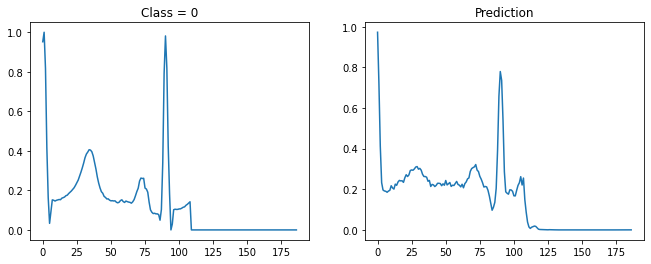

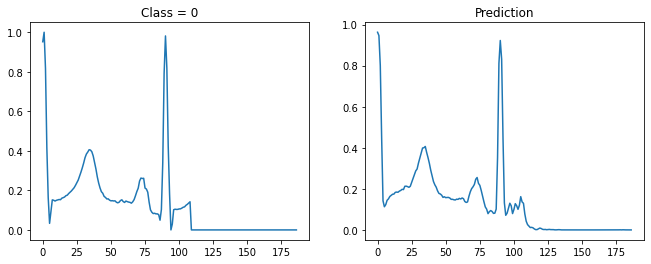

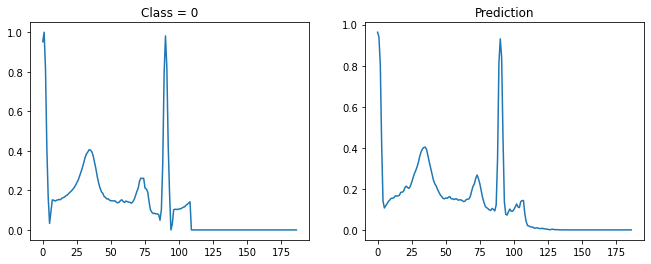

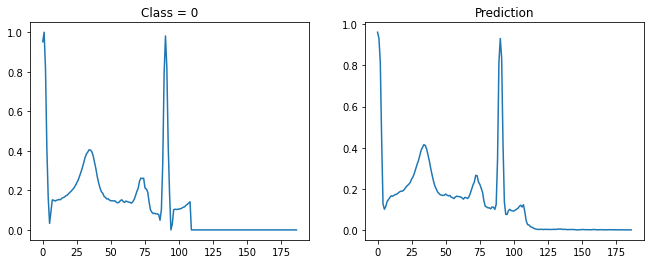

In [ ]:
#auto encoder
for i in range(len(modelAutoencoders)):
    model = modelAutoencoders[i]
    pred_test = model.predict(X_test_ptbdb)

    plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    plt.plot(X_test_ptbdb[0])
    plt.title("Class = " + str(Y[0])) 
    plt.subplot(1,2,2)
    plt.plot(pred_test[0])
    plt.title("Prediction")

### Encoders PTBDB

In [ ]:
aucroc = AUC(curve='ROC',name='roc')
aucpr = AUC(curve='PR',name='pr')
nclass = 1
currentLoss = losses.binary_crossentropy
currentMetrics =[aucpr,aucroc,'acc']
activationFunction = activations.sigmoid

def mlp():
  inp = Input(shape=(187))
  dense = Dense(128, activation=activations.relu)(inp)
  drop = Dropout(rate=0.2)(dense)
  dense = Dense(64, activation=activations.relu)(drop)
  dense = Dense(64, activation=activations.relu)(dense)
  dense = Dense(64, activation=activations.relu)(dense)
  drop = Dropout(rate=0.2)(dense)
  dense = Dense(64, activation=activations.relu)(drop)
  dense = Dense(32, activation=activations.relu)(dense)
  dense = Dense(16, activation=activations.relu)(dense)
  dense = Dense(8, activation=activations.relu)(dense)
  dense2 = Dense(nclass, activation=activationFunction)(dense)
  model = models.Model(inputs=inp, outputs=dense2)
  opt = optimizers.Adam(0.001)
  model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
  model.summary()
  return model

def mlp2():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(128, activation=activations.relu)(drop)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp3():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(128, activation=activations.relu)(drop)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp4():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(32, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model
  
def mlp5(): #best in both datasets
    inp = Input(shape=(187))
    dense = Dense(256, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(128, activation=activations.relu)(drop)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp6():
    inp = Input(shape=(187))
    dense = Dense(256, activation=activations.relu)(inp)
    dense = Dense(32, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp7():
    inp = Input(shape=(187))
    dense = Dense(64, activation=activations.relu)(inp)
    dense = Dense(64, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(64, activation=activations.relu)(drop)
    dense = Dense(64, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(64, activation=activations.relu)(drop)
    dense = Dense(32, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp8():
    inp = Input(shape=(187))
    dense = Dense(150, activation=activations.relu)(inp)
    dense = Dense(100, activation=activations.relu)(dense)
    dense = Dense(50, activation=activations.relu)(dense)
    dense = Dense(50, activation=activations.relu)(dense)
    dense = Dense(30, activation=activations.relu)(dense)
    dense = Dense(10, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp9():
    inp = Input(shape=(187))
    dense = Dense(250, activation=activations.relu)(inp)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp10():
    inp = Input(shape=(187))
    dense = Dense(157, activation=activations.relu)(inp)
    dense = Dense(127, activation=activations.relu)(dense)
    dense = Dense(97, activation=activations.relu)(dense)
    dense = Dense(67, activation=activations.relu)(dense)
    dense = Dense(37, activation=activations.relu)(dense)
    dense = Dense(7, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp11():
    inp = Input(shape=(187))
    dense = Dense(150, activation=activations.relu)(inp)
    dense = Dense(120, activation=activations.relu)(dense)
    dense = Dense(100, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(60, activation=activations.relu)(drop)
    dense = Dense(50, activation=activations.relu)(dense)
    dense = Dense(30, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(10, activation=activations.relu)(drop)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp12():
    inp = Input(shape=(187))
    dense = Dense(150, activation=activations.relu)(inp)
    dense = Dense(80, activation=activations.relu)(dense)
    dense = Dense(60, activation=activations.relu)(dense)
    dense = Dense(60, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp13():
    inp = Input(shape=(187))
    dense = Dense(100, activation=activations.relu)(inp)
    dense = Dense(40, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp14():
    inp = Input(shape=(187))
    dense = Dense(100, activation=activations.relu)(inp)
    dense = Dense(70, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(70, activation=activations.relu)(drop)
    dense = Dense(30, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp15():
    inp = Input(shape=(187))
    dense = Dense(200, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(300, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(200, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(150, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(100, activation=activations.relu)(drop)
    dense = Dense(50, activation=activations.relu)(dense)
    dense = Dense(25, activation=activations.relu)(dense)
    dense = Dense(10, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp16():
    inp = Input(shape=(187))
    dense = Dense(187, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(230, activation=activations.relu)(drop)
    drop = Dropout(rate=0.2)(dense)
    dense = Dense(230, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(187, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(100, activation=activations.relu)(drop)
    dense = Dense(10, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp17():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(256, activation=activations.relu)(drop)
    dense = Dense(128, activation=activations.relu)(dense)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(32, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(32, activation=activations.relu)(drop)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp18():
    inp = Input(shape=(187))
    dense = Dense(150, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(100, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(50, activation=activations.relu)(drop)
    dense = Dense(25, activation=activations.relu)(dense)
    dense = Dense(10, activation=activations.relu)(dense)
    dense = Dense(5, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp19():
    inp = Input(shape=(187))
    dense = Dense(500, activation=activations.relu)(inp)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp20():
    inp = Input(shape=(187))
    dense = Dense(300, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(50, activation=activations.relu)(drop)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp21():
    inp = Input(shape=(187))
    dense = Dense(150, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(100, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(100, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(50, activation=activations.relu)(drop)
    dense = Dense(20, activation=activations.relu)(drop)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

In [ ]:
fitEncoders = True

if fitEncoders:

    modelMLP = mlp()
    modelMLP2 = mlp2()
    modelMLP3 = mlp3()
    modelMLP4 = mlp4()
    modelMLP5 = mlp5()
    modelMLP6 = mlp6()
    modelMLP7 = mlp7()
    modelMLP8 = mlp8()
    modelMLP9 = mlp9()
    modelMLP10 = mlp10()
    modelMLP11 = mlp11()
    modelMLP12 = mlp12()
    modelMLP13 = mlp13()
    modelMLP14 = mlp14()
    modelMLP15 = mlp15()
    modelMLP16 = mlp16()
    modelMLP17 = mlp17()
    modelMLP18 = mlp18()
    modelMLP19 = mlp19()
    modelMLP20 = mlp20()
    modelMLP21 = mlp21()
    modelsMLP = [modelMLP,modelMLP2,modelMLP3,modelMLP4,modelMLP5,modelMLP6,modelMLP7,modelMLP8,modelMLP9,modelMLP10,modelMLP11,modelMLP12,modelMLP13,modelMLP14,modelMLP15,modelMLP16,modelMLP17,modelMLP18,modelMLP19,modelMLP20,modelMLP21]

    for i in range(len(modelsMLP)):
        model = modelsMLP[i]
        file_path = "encoder"+str(i+1)+"_ptbdb.h5"
        checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        early = EarlyStopping(monitor="val_acc", mode="max", patience=15, verbose=1)
        redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=10, verbose=2)
        callbacks_list = [checkpoint, early, redonplat]
        model.fit(X_ptbdb, Y_ptbdb, epochs=100, verbose=2, callbacks=callbacks_list, validation_split=0.1)
        model.load_weights(file_path)
else:
    modelsMLP = []
    for i in range(21):
        modelsMLP.append(load_model('encoder'+str(i+1)+'_ptbdb.h5'))

In [ ]:
predictionsBestEncodersPTBDB = []
f1scoresEncoders = []
for i in range(len(modelsMLP)):
    model = modelsMLP[i]
    pred_test = model.predict(X_test_ptbdb)
    pred_test = (pred_test>0.5).astype(np.int8)
    print("Encoder " + str(i+1))

    f1 = f1_score(Y_test_ptbdb, pred_test)
    f1scoresEncoders.append(f1)
    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test_ptbdb, pred_test)

    print("Test accuracy score : %s \n"% acc)
    if f1>=0.983:
        predictionsBestEncodersPTBDB.append(pred_test)

print('Best encoder is encoder number',np.argmax(f1scoresEncoders) + 1)
print(str(len(predictionsBestEncodersPTBDB)) + ' encoders taken into account for ensemble part')

Encoder 1
Test f1 score : 0.9838479809976247 
Test accuracy score : 0.9766403297835795 

Encoder 2
Test f1 score : 0.9837476099426387 
Test accuracy score : 0.9766403297835795 

Encoder 3
Test f1 score : 0.9828734538534729 
Test accuracy score : 0.9752662315355548 

Encoder 4
Test f1 score : 0.9821640903686089 
Test accuracy score : 0.9742356578495363 

Encoder 5
Test f1 score : 0.9857346647646219 
Test accuracy score : 0.979388526279629 

Encoder 6
Test f1 score : 0.9823893384102809 
Test accuracy score : 0.9745791824115424 

Encoder 7
Test f1 score : 0.9802239695020252 
Test accuracy score : 0.9714874613534867 

Encoder 8
Test f1 score : 0.9840286054827175 
Test accuracy score : 0.9769838543455857 

Encoder 9
Test f1 score : 0.9794945159752027 
Test accuracy score : 0.9704568876674682 

Encoder 10
Test f1 score : 0.9850107066381156 
Test accuracy score : 0.9783579525936105 

Encoder 11
Test f1 score : 0.981904761904762 
Test accuracy score : 0.9738921332875301 

Encoder 12
Test f1 sc

### Encoders MITBIH

In [ ]:
nclass = 5
currentLoss = losses.sparse_categorical_crossentropy
currentMetrics =['acc']
activationFunction = activations.softmax

def mlp():
  inp = Input(shape=(187))
  dense = Dense(128, activation=activations.relu)(inp)
  drop = Dropout(rate=0.2)(dense)
  dense = Dense(64, activation=activations.relu)(drop)
  dense = Dense(64, activation=activations.relu)(dense)
  dense = Dense(64, activation=activations.relu)(dense)
  drop = Dropout(rate=0.2)(dense)
  dense = Dense(64, activation=activations.relu)(drop)
  dense = Dense(32, activation=activations.relu)(dense)
  dense = Dense(16, activation=activations.relu)(dense)
  dense = Dense(8, activation=activations.relu)(dense)
  dense2 = Dense(nclass, activation=activationFunction)(dense)
  model = models.Model(inputs=inp, outputs=dense2)
  opt = optimizers.Adam(0.001)
  model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
  model.summary()
  return model

def mlp2():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(128, activation=activations.relu)(drop)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp3():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(128, activation=activations.relu)(drop)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp4():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(32, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model
  
def mlp5(): #best in both datasets
    inp = Input(shape=(187))
    dense = Dense(256, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(128, activation=activations.relu)(drop)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp6():
    inp = Input(shape=(187))
    dense = Dense(256, activation=activations.relu)(inp)
    dense = Dense(32, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp7():
    inp = Input(shape=(187))
    dense = Dense(64, activation=activations.relu)(inp)
    dense = Dense(64, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(64, activation=activations.relu)(drop)
    dense = Dense(64, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(64, activation=activations.relu)(drop)
    dense = Dense(32, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp8():
    inp = Input(shape=(187))
    dense = Dense(150, activation=activations.relu)(inp)
    dense = Dense(100, activation=activations.relu)(dense)
    dense = Dense(50, activation=activations.relu)(dense)
    dense = Dense(50, activation=activations.relu)(dense)
    dense = Dense(30, activation=activations.relu)(dense)
    dense = Dense(10, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp9():
    inp = Input(shape=(187))
    dense = Dense(250, activation=activations.relu)(inp)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp10():
    inp = Input(shape=(187))
    dense = Dense(157, activation=activations.relu)(inp)
    dense = Dense(127, activation=activations.relu)(dense)
    dense = Dense(97, activation=activations.relu)(dense)
    dense = Dense(67, activation=activations.relu)(dense)
    dense = Dense(37, activation=activations.relu)(dense)
    dense = Dense(7, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp11():
    inp = Input(shape=(187))
    dense = Dense(150, activation=activations.relu)(inp)
    dense = Dense(120, activation=activations.relu)(dense)
    dense = Dense(100, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(60, activation=activations.relu)(drop)
    dense = Dense(50, activation=activations.relu)(dense)
    dense = Dense(30, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(10, activation=activations.relu)(drop)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp12():
    inp = Input(shape=(187))
    dense = Dense(150, activation=activations.relu)(inp)
    dense = Dense(80, activation=activations.relu)(dense)
    dense = Dense(60, activation=activations.relu)(dense)
    dense = Dense(60, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp13():
    inp = Input(shape=(187))
    dense = Dense(100, activation=activations.relu)(inp)
    dense = Dense(40, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp14():
    inp = Input(shape=(187))
    dense = Dense(100, activation=activations.relu)(inp)
    dense = Dense(70, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(70, activation=activations.relu)(drop)
    dense = Dense(30, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp15():
    inp = Input(shape=(187))
    dense = Dense(200, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(300, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(200, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(150, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(100, activation=activations.relu)(drop)
    dense = Dense(50, activation=activations.relu)(dense)
    dense = Dense(25, activation=activations.relu)(dense)
    dense = Dense(10, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp16():
    inp = Input(shape=(187))
    dense = Dense(187, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(230, activation=activations.relu)(drop)
    drop = Dropout(rate=0.2)(dense)
    dense = Dense(230, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(187, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(100, activation=activations.relu)(drop)
    dense = Dense(10, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp17():
    inp = Input(shape=(187))
    dense = Dense(128, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(256, activation=activations.relu)(drop)
    dense = Dense(128, activation=activations.relu)(dense)
    dense = Dense(64, activation=activations.relu)(dense)
    dense = Dense(32, activation=activations.relu)(dense)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(32, activation=activations.relu)(drop)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp18():
    inp = Input(shape=(187))
    dense = Dense(150, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(100, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(50, activation=activations.relu)(drop)
    dense = Dense(25, activation=activations.relu)(dense)
    dense = Dense(10, activation=activations.relu)(dense)
    dense = Dense(5, activation=activations.relu)(dense)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp19():
    inp = Input(shape=(187))
    dense = Dense(500, activation=activations.relu)(inp)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp20():
    inp = Input(shape=(187))
    dense = Dense(300, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(50, activation=activations.relu)(drop)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

def mlp21():
    inp = Input(shape=(187))
    dense = Dense(150, activation=activations.relu)(inp)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(100, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(100, activation=activations.relu)(drop)
    drop = Dropout(rate=0.1)(dense)
    dense = Dense(50, activation=activations.relu)(drop)
    dense = Dense(20, activation=activations.relu)(drop)
    dense = Dense(nclass, activation=activationFunction)(dense)
    model = models.Model(inputs=inp, outputs=dense)
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=currentLoss, metrics=currentMetrics)
    model.summary()
    return model

In [ ]:
fitEncoders = True

if fitEncoders:

    modelMLP = mlp()
    modelMLP2 = mlp2()
    modelMLP3 = mlp3()
    modelMLP4 = mlp4()
    modelMLP5 = mlp5()
    modelMLP6 = mlp6()
    modelMLP7 = mlp7()
    modelMLP8 = mlp8()
    modelMLP9 = mlp9()
    modelMLP10 = mlp10()
    modelMLP11 = mlp11()
    modelMLP12 = mlp12()
    modelMLP13 = mlp13()
    modelMLP14 = mlp14()
    modelMLP15 = mlp15()
    modelMLP16 = mlp16()
    modelMLP17 = mlp17()
    modelMLP18 = mlp18()
    modelMLP19 = mlp19()
    modelMLP20 = mlp20()
    modelMLP21 = mlp21()
    modelsMLP = [modelMLP,modelMLP2,modelMLP3,modelMLP4,modelMLP5,modelMLP6,modelMLP7,modelMLP8,modelMLP9,modelMLP10,modelMLP11,modelMLP12,modelMLP13,modelMLP14,modelMLP15,modelMLP16,modelMLP17,modelMLP18,modelMLP19,modelMLP20,modelMLP21]

    for i in range(len(modelsMLP)):
        model = modelsMLP[i]
        file_path = "encoder"+str(i+1)+"_MITBIH.h5"
        checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        early = EarlyStopping(monitor="val_acc", mode="max", patience=15, verbose=1)
        redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=10, verbose=2)
        callbacks_list = [checkpoint, early, redonplat]
        model.fit(X_ptbdb, Y_ptbdb, epochs=100, verbose=2, callbacks=callbacks_list, validation_split=0.1)
        model.load_weights(file_path)
else:
    modelsMLP = []
    for i in range(21):
        modelsMLP.append(load_model('encoder'+str(i+1)+'_MITBIH.h5'))

In [ ]:
predictionsBestEncodersMITBIH = []
f1scoresEncoders = []
for i in range(len(modelsMLP)):
    model = modelsMLP[i]
    pred_test = model.predict(X_test)
    pred_test = np.argmax(pred_test, axis=-1)
    print("Encoder " + str(i+1))

    f1 = f1_score(Y_test, pred_test,average="macro")
    f1scoresEncoders.append(f1)
    print("Test f1 score : %s "% f1)

    acc = accuracy_score(Y_test, pred_test)

    print("Test accuracy score : %s \n"% acc)
    if f1>=0.91:
        predictionsBestEncodersMITBIH.append(pred_test)

print('Best encoder is encoder number',np.argmax(f1scoresEncoders) + 1)
print(str(len(predictionsBestEncodersMITBIH)) + ' encoders taken into account for ensemble part')

Encoder 1
Test f1 score : 0.8964076470151339 
Test accuracy score : 0.9811346610634022 

Encoder 2
Test f1 score : 0.9127260035851457 
Test accuracy score : 0.9836926731226019 

Encoder 3
Test f1 score : 0.8903879231686103 
Test accuracy score : 0.9807692307692307 

Encoder 4
Test f1 score : 0.8969132927499903 
Test accuracy score : 0.9807235519824593 

Encoder 5
Test f1 score : 0.9170602250894155 
Test accuracy score : 0.983921067056459 

Encoder 6
Test f1 score : 0.9039726170070278 
Test accuracy score : 0.9820482367988306 

Encoder 7
Test f1 score : 0.8980585457183551 
Test accuracy score : 0.9804494792618308 

Encoder 8
Test f1 score : 0.9012899275147799 
Test accuracy score : 0.981545770144345 

Encoder 9
Test f1 score : 0.9006813796899206 
Test accuracy score : 0.9814087337840307 

Encoder 10
Test f1 score : 0.9069879475591405 
Test accuracy score : 0.9821395943723734 

Encoder 11
Test f1 score : 0.9055992634387465 
Test accuracy score : 0.9817741640782021 

Encoder 12
Test f1 sc

# Task 3 : Ensemble approach

In [ ]:
includeBestEncoders = False
includeLgbm = True
includeBestCNN = True
includeBestRNN = True

predictionsPTBDB = []
predictionsMITBIH = []

if includeBestEncoders:

    for predictionEncoder in predictionsBestEncodersPTBDB:
        predictionsPTBDB.append(predictionEncoder)

    for predictionEncoder in predictionsBestEncodersMITBIH:
        predictionsMITBIH.append(predictionEncoder)

if includeLgbm:
    predictionsPTBDB.append(pred_test_lgb_ptbdb.reshape(Y_test_ptbdb.shape[0],1))
    predictionsMITBIH.append(pred_test_lgb_mitbih)

if includeBestCNN:
    predictionsPTBDB.append(pred_test11_ptbdb)
    predictionsMITBIH.append(pred_test19)

if includeBestRNN:
    predictionsPTBDB.append(pred_test_gru_ptbdb)
    predictionsMITBIH.append(pred_test_gru_mitbih)

print('PTBDB : '+ str(len(predictionsPTBDB)) + ' predictions included')
print('MITBIH : '+ str(len(predictionsMITBIH)) + ' predictions included')

PTBDB : 3 predictions included
MITBIH : 3 predictions included


In [ ]:
#make the labels vote to the most present class, in case they are in same proportion, the first one is taken
def predict_average(list_predictions):
    prediction = []
    for i in range(list_predictions[0].shape[0]):
        labels, counts = np.unique(list_predictions[:,i], return_counts=True) 
        prediction.append(labels[np.argmax(counts)])
    return prediction

In [ ]:
averagePTBDB = predict_average(np.array(predictionsPTBDB))
print('scores average PTBDB')

f1 = f1_score(Y_test_ptbdb, averagePTBDB)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test_ptbdb, averagePTBDB)

print("Test accuracy score : %s \n"% acc)

averageMITBIH = predict_average(np.array(predictionsMITBIH))
print('scores average MITBIH')

f1 = f1_score(Y_test, averageMITBIH,average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, averageMITBIH)

print("Test accuracy score : %s \n"% acc)

scores average PTBDB
Test f1 score : 0.9983368971252079 
Test accuracy score : 0.9975953280659567 

scores average MITBIH
Test f1 score : 0.9347302289923783 
Test accuracy score : 0.988991412388087 



# Task 4 : Transfer learning

## Option 1

In [ ]:
#Transfer Learning code 
#Option 1

pretrained_mitbih_rnn = load_model("gru_mitbih.h5")
pretrained_mitbih_rnn.summary()

#cloned_pretrained is our best mitbih pretrained gru, with the fully connected layers removed

cloned_pretrained = Sequential()
for layer in pretrained_mitbih_rnn.layers[:-2]: # go through until last layer (it's in fact 4 layers, fc, relu, fc, and softmax)
    cloned_pretrained.add(layer)
cloned_pretrained.summary()
opt = tf.keras.optimizers.Adam(0.001) #tf.optimizers.SGD(0.001)
cloned_pretrained.compile(optimizer=opt, loss=losses.binary_crossentropy)

representations_train_ptbdb = cloned_pretrained.predict(X_ptbdb)
representations_test_ptbdb = cloned_pretrained.predict(X_test_ptbdb) 


#small_ffnn is a small feed-forward neural network roughly equivalent to the removed layers

small_ffnn =  Sequential()
small_ffnn.add(Dense(128, activation=activations.relu, input_shape = representations_train_ptbdb.shape[1:]))
small_ffnn.add(Dense(64, activation=activations.relu))
small_ffnn.add(Dense(1, activation = activations.sigmoid))
small_ffnn.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc',tf.keras.metrics.AUC(curve="ROC",name="ROC"),tf.keras.metrics.AUC(curve="PR",name="PR")])
small_ffnn.summary()

file_path = "TL1_gru_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=50, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=30, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

small_ffnn.fit(representations_train_ptbdb, Y_ptbdb, epochs=100, verbose=2, callbacks=callbacks_list, validation_split=0.1)

pred_test = small_ffnn.predict(representations_test_ptbdb)
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test_ptbdb, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test_ptbdb, pred_test)

print("Test accuracy score : %s "% acc)

In [ ]:
#Option 1 continued
#To evaluate the contribution of pretraining we can compare the metric values of the previous small neural network
#with the metric values that an almost equivalent feed-forward neural network produces, which however does not receive
# the representations as inputs but rather the raw data. The results speak for themselves as we get:

#small_raw_ffnn
#Test f1 score : 0.9714964370546318 
#Test accuracy score : 0.9587770525592579 

#small_ffnn
# Test f1 score : 0.9851169383416016 
# Test accuracy score : 0.9783579525936105 

#In conclusion, we see that transfer learning has sped up the convergence significantly
small_raw_ffnn =  Sequential()
small_raw_ffnn.add(Dense(128, activation=activations.relu, input_shape = (187,)))
small_raw_ffnn.add(Dense(64, activation=activations.relu))
small_raw_ffnn.add(Dense(1, activation = activations.sigmoid))
small_raw_ffnn.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc',tf.keras.metrics.AUC(curve="ROC",name="ROC"),tf.keras.metrics.AUC(curve="PR",name="PR")])
small_raw_ffnn.summary()

file_path = "TL1_raw_gru_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=50, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=30, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

small_raw_ffnn.fit(np.squeeze(X_ptbdb), Y_ptbdb, epochs=100, verbose=2, callbacks=callbacks_list, validation_split=0.1)

pred_test = small_raw_ffnn.predict(np.squeeze(X_test_ptbdb))
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test_ptbdb, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test_ptbdb, pred_test)

print("Test accuracy score : %s "% acc)

## Option 2 

In [ ]:
#Transfer Learning code 
#Option 2

pretrained_mitbih_rnn_2 = load_model("gru_mitbih.h5")

cloned_pretrained_2 = Sequential()
for layer in pretrained_mitbih_rnn_2.layers[:-2]: # go through until last layer (it's in fact 2 layers, fc and softmax)
    cloned_pretrained_2.add(layer)


cloned_pretrained_2.add(Dense(64, activation = activations.relu))
cloned_pretrained_2.add(Dense(1, activation = activations.sigmoid))

cloned_pretrained_2.summary()
opt = tf.keras.optimizers.Adam(0.001) #tf.optimizers.SGD(0.001)
cloned_pretrained_2.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc',tf.keras.metrics.AUC(curve="ROC",name="ROC"),tf.keras.metrics.AUC(curve="PR",name="PR")])



file_path = "TL2_gru_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=50, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=30, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

cloned_pretrained_2.fit(X_ptbdb, Y_ptbdb, epochs=80, verbose=2, callbacks=callbacks_list, validation_split=0.1)

pred_test = cloned_pretrained_2.predict(X_test_ptbdb)
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test_ptbdb, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test_ptbdb, pred_test)

print("Test accuracy score : %s "% acc)